# Function Approximation with a Multilayer Perceptron

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Approximation of 1D functions using a simple multilayer perceptron (MLP)
* Implementation of MLP using PyTorch
* Approximation of 2D functions using a simple MLP with configurable number of hidden units

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


This code approximates a given 1D and later 2D function with a multilayer perceptron with a single hidden layer.

Select one of the given functions or add a new one.

Also select the activation function, which can be either `'nn.Tanh()'` or `'nn.ReLU()'` 

In [2]:
activation_function = nn.Tanh()

function_select = 1

def myfun(x):
    functions = {
        1: np.power(x,2), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: (np.power(x,3)+ np.power(x-10,4))/np.power(x-20,2), # polynom
        6: 1+np.power(x,2)/4000-np.cos(x) # Griewank function
        # for Griewank, we need more than 50, does not generalize well (we must make sure not to have more parameters than samples in order to avoid overfitting)
    }
    return functions.get(function_select)


Define the range of the **training data** and of the final **evaluation data**. (they may differ)
The `batch_size` parameter defines how many examples we have in our training set

In [3]:
# Generate training data.
batch_size = 32
x_train_fix = np.linspace(-1, 7, num=batch_size).reshape(-1,1)

# Generate the evaluation data. 
# (exceeds the range of the training data to evaluate the prediction capabilities)
x_eval_fix = np.linspace(-3, 10, num=batch_size).reshape(-1,1)


Create a **multilayer perceptron** with a single hidden layer and multiple inputs. The steps for creating the model are
1. Build the model. We use one dense layer followed by a linear readout layer. We use `tanh` as activation function, but you can change it to `relu` to see a different behavior using piecewise linear approximation.
2. Compile the model. We use the Adam (= Adaptive Moment Estimation) optimizer, which is a variant of the pure stochastic gradient descent optimizer optimized for improved convergence. The loss function is a mean squared error.
3. Train the model.

This MLP can be used both, for 1D and 2D functions.


In [4]:
# generate weights and biases for the two layers
def train_model_simple(x_train, y_train, x_eval, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    x_eval_tensor = torch.from_numpy(x_eval).float().to(device)

    y_train_tensor = torch.from_numpy(y_train).float().to(device)    
       
    # predefined linear layers, parameters are input and output neurons
    layer1 = nn.Linear(x_train.shape[1], units).to(device)
    layer2 = nn.Linear(units, 1, bias=False).to(device) # do not use bias on second layer
    
    # gather parameters of both layers
    parameters = list(layer1.parameters()) + list(layer2.parameters())
    
    # Adam and MSE Loss
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    for epoch in range(epochs):
        yhat = layer2(activation_function(layer1(x_train_tensor)))
            
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()

    yhat_eval = layer2(activation_function(layer1(x_eval_tensor)))       
    # return yhat as numpy array, in the 1D-case, convert back to 1D
    #if x_train.shape[1] == 1:
    #    return yhat[:,0].detach().numpy(), yhat_eval[:,0].detach().numpy()
    #else:
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()

To approximate the given function, we apply the following steps:
* **Generate training set**: This is a simple linspace in our case. (we already did this)
* **Preprocess the data**. We scale the data (X and Y) to a range of [-1,1] before feeding to the model.
* **Build**, **train** and **apply** the model.
* Postprocess the data. Then, we feed the evaluation dataset (which is different from the training dataset) into the model to show how well it generalizes


In [5]:
def approx_1d_function(x_train, x_eval, units, epochs): 
    # Generate labels for training data (here: the image of the selected function applied to X_train)
    y_train = myfun(x_train)
    # Scale the train data (x), the evaluation data (x_eval) and the labels (y) to the range [-1, 1].
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x_scaled = x_scaler.fit_transform(x_train_fix)
    y_scaled = y_scaler.fit_transform(y_train)
    x_eval_scaled = x_scaler.transform(x_eval_fix)
    
    # Build and apply multilayer perceptron.    
    _, result_eval = train_model_simple(x_scaled, y_scaled, x_eval_scaled, units, epochs)

    # Rescale the result to original range.
    res_rescaled = y_scaler.inverse_transform(result_eval)
    
    # Calculate the label (function value) for the evaluation training set.
    y_eval = myfun(x_eval)
    
    return x_eval, res_rescaled, y_eval

In [6]:
def plot_1d_function(x_train, x_eval, predictions, labels, units, epochs):
    fig = plt.figure(1, figsize=(18,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
    plt.plot(x_train, myfun(x_train), '.', color='royalblue')
    plt.grid(which='both');
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('%d neurons in hidden layer with %d epochs of training' % (units ,epochs))
    plt.legend(['Function f(x)', 'MLP output g(x)', 'Training set'])
    ax = fig.add_subplot(1, 2, 2)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, np.abs(predictions-myfun(x_eval)), '-', label='output', color='firebrick', linewidth=2.0)
    plt.grid(which='both');
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('Absolute difference between prediction and actual function')
    plt.legend(['Error |f(x)-g(x)|'])
    #plt.savefig('KerasMLP_%d_neurons.pdf' % units, bbox_inches='tight')
    plt.show()        

Finally, carry out the approximation of the function and plot results.

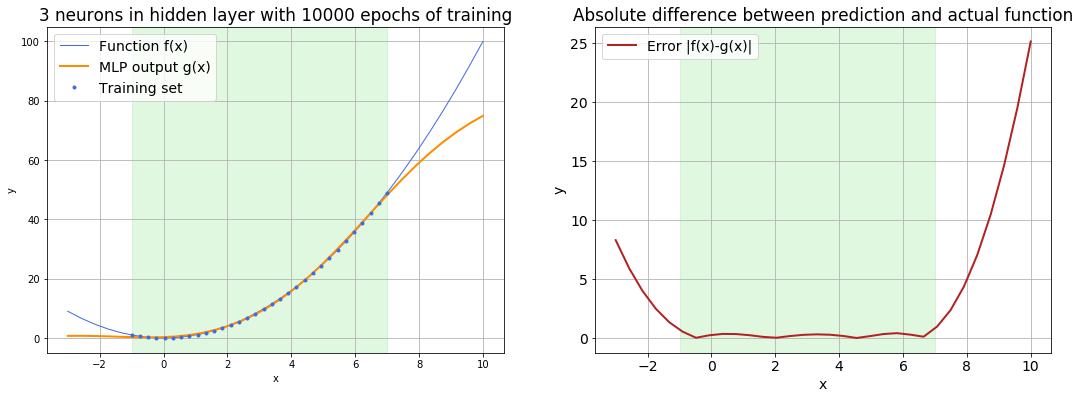

In [7]:
units = 3
epochs = 10000
x, predictions, labels = approx_1d_function(x_train=x_train_fix, x_eval=x_eval_fix, units=units, epochs=epochs)
plot_1d_function(x_train_fix, x_eval_fix, predictions, labels, units, epochs)

## Function approximation in 2D 
Our training data is now a meshgrid of x,y values.  
Select one of the given two functions below or add a new one by yourself

In [8]:
fun_2d = 2

def my2dfun(x1, x2):
    functions = {
        1: np.power(x1,2)+np.power(x2,2), # quadratic function
        2: np.sin(np.sqrt(x1**2 + x2**2)) # sinus
    }
    return functions.get(fun_2d)

Generate **training data**, use `batch_size` entries in each dimension.


In [9]:
batch_size = 16 # Number of grid steps per dimension (batch_size**2 equals number of training samples).
x1 = np.linspace(-3.0, 3.0, num=batch_size).reshape(-1,1)
x2 = np.linspace(-3.0, 3.0, num=batch_size).reshape(-1,1)


In [10]:
def plot_2d_function(X1, X2, Y, res):    
    fig = plt.figure(1,figsize=(24,12))
    plt.rcParams.update({'font.size': 18})
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), Y.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(X1, X2, Y, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Function.')
    ax = fig.add_subplot(2,3, 2, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), res.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(X1, X2, res, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Prediction.')
    ax = fig.add_subplot(2,3, 3, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), np.abs(res-Y).flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 6)
    im = ax.contourf(X1, X2, np.abs(res-Y), levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Absolute difference between \n prediction and actual function')
    #plt.savefig('2d_fun%d_units%d.pdf' % (fun_2d, units),bbox_inches='tight')

For the approximation of the 2D function, our training set is a meshgrid.  
After preparation of the data, we can feed the data to the model.   
Note that we use the **same model** as above for the 1D function.
The only difference is the shape of the training elements. (In the 1D case, each element was an $x$-value, labelled 
with the return value of the function $f(x)$. Now each element is a vector $\boldsymbol{x}=\begin{pmatrix}x_1 & x_2\end{pmatrix}$, labelled with the return value of the function $f(\boldsymbol{x})$.)


In [11]:
def approx_2d_function(x1_train, x2_train, units, epochs):
    X1, X2 = np.meshgrid(x1_train, x2_train)
    # Generate labels.
    Y = my2dfun(X1, X2).reshape(-1,1)
    
    # Scale X1 and X2 values to the range [-1, 1]. 
    x1_scaler = MinMaxScaler(feature_range=(-1, 1))
    x2_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x1_scaled = x1_scaler.fit_transform(x1_train)
    x2_scaled = x2_scaler.fit_transform(x2_train)
    y_scaled = y_scaler.fit_transform(Y)
    X1_scaled, X2_scaled = np.meshgrid(x1_scaled, x2_scaled)
    cord = np.stack((X1_scaled, X2_scaled), axis=-1).reshape(batch_size**2, 2)
    
    _, result = train_model_simple(cord, y_scaled, cord, units, epochs)

    # Rescale data to original range.
    res_rescaled = y_scaler.inverse_transform(result)
    return res_rescaled.reshape(batch_size, batch_size)

Approximate function using the MLP and plot results.


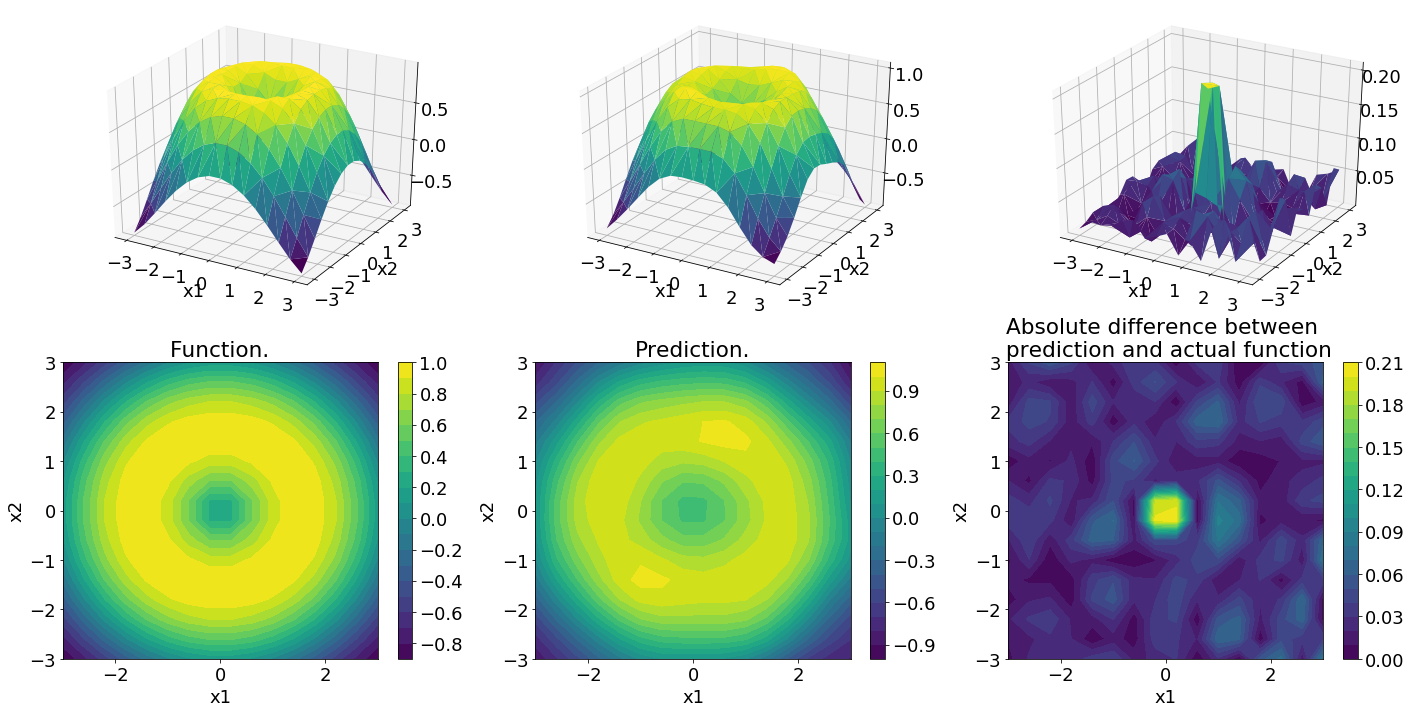

In [12]:
units = 10
epochs = 20000
res = approx_2d_function(x1, x2, units, epochs)
X1,X2 = np.meshgrid(x1,x2)
Y = my2dfun(X1,X2)
plot_2d_function(X1,X2,Y,res)


## Function Approximation with (basic) PyTorch
Until now, we used PyTorhc with the built-in layers. We can also implement the  multilayer perceptron with basic, pure PyTorch code. This will give you a glimpse into the world of PyTorch. 

In [13]:
function_select = 2

def pt_fun(x):
    functions = {
        1: np.square(x), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: (np.power(x,3)+ np.power(x-10,4))/np.power(x-20,2), # polynom
        6: 1+np.power(x,2)/4000-np.cos(x) # Griewank function
    }
    return functions.get(function_select)


Create Tensorflow computation graph. A tf graph is a series of tf operations arranged into a graph.  
This graph contains nodes ([tf.Operation](https://www.tensorflow.org/api_docs/python/tf/Operation) -> consumes and produces tensors) 
and edges ([tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) -> values that flow through the graph).

In [14]:
# generate weights and biases for the two layers
def train_model_manual(x_train, y_train, x_eval, units, epochs):
    # define weights to be optimized
    w1 = torch.randn(units, requires_grad=True, dtype=torch.float, device=device)
    b1 = torch.randn(units, requires_grad=True, dtype=torch.float, device=device)    
    w2 = torch.randn(units, requires_grad=True, dtype=torch.float, device=device)    

    # convert to Pytorch and copy to device
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)    

    x_eval_tensor = torch.from_numpy(x_eval).float().to(device)

    # use Adam and tell Adam to optimize w1, b1 and w2        
    optimizer = optim.Adam([w1,b1,w2])
   
   
    # iterate and optimize
    
    for epoch in range(epochs):        
        # output of the MLP
        yhat = (activation_function(x_train_tensor * w1 + b1) * w2).sum(1)
        
        # loss is MSE
        loss = ((yhat - y_train_tensor[:,0])**2).mean()
    
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
    yhat_eval = (activation_function(x_eval_tensor * w1 + b1) * w2).sum(1)               
    # return yhat as numpy array
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()

Specify model parameters and run model.

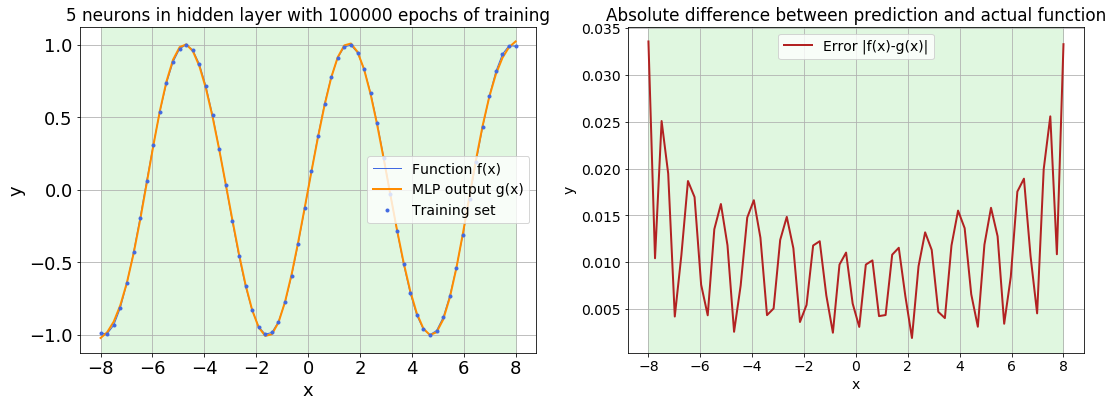

In [15]:
batch_size = 64 # Length of training vector.
units = 5
epochs = 100000


x_train_pt = np.linspace(-8, 8, batch_size).reshape(-1,1)

# Generate labels for training data (here: the image of the selected function applied to X_train)
y_train_pt = pt_fun(x_train_pt)

_, result_eval = train_model_manual(x_train_pt, y_train_pt, x_train_pt, units, epochs)

plot_1d_function(x_train_pt, x_train_pt.flatten(), result_eval, y_train_pt, units, epochs)